In [4]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/mila/l/leo.gagnon/latent_control')

from wandb import Api
import pandas as pd
from task import MetaLearningTask
import seaborn as sns
import torch
from models.gpt import GPT
from models.mamba import MambaLMHeadModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prequential stuff

In [7]:
runs = Api().runs(
    path="leogagnon/latent_control", filters={"config.sweep_id": "mamba_2024-10-18-13-54-03"}
)
runs = [run.id for run in runs]

df = pd.DataFrame(
    columns=[
        "method",
        "model",
        "seed",
        "seq_id",
        "n_samples",
        "f_kl",
        "b_kl",
        "nll",
    ]
)

N_RUNS = 25
C_LEN = 250

# Hardcoded this part cuz made an error in checkpointing

for id in runs:
    task = MetaLearningTask(id).cuda()
    task: MetaLearningTask
    method = "regular" if task.cfg.data.context_length == [200,200] else "preq"
    model = "GPT" if isinstance(task.model, GPT) else "Mamba"

    pp_dict = task.evaluate_pp(N_RUNS, C_LEN + 1, 4)

    for i in range(N_RUNS):
        for j in range(C_LEN):
            df.loc[len(df)] = {
                "method": method,
                "model": model,
                "seed": task.cfg.data.seed,
                "seq_id": i,
                "n_samples": j,
                "f_kl": pp_dict['ForwardKL'][i, j].item(),
                "b_kl": pp_dict['BackwardKL'][i, j].item(),
                "nll": pp_dict["ModelNLL"][i, j].item(),
            }

df.to_csv('prequential_mamba.csv')

Loaded dataset : (11288/1000)
Loaded checkpoing : epoch=438,step=19750.ckpt
number of parameters: 18.94M
Loaded dataset : (11288/1000)
Loaded checkpoing : epoch=438,step=19750.ckpt
number of parameters: 18.94M
Loaded dataset : (11288/1000)
Loaded checkpoing : epoch=427,step=19250.ckpt
number of parameters: 18.94M
Loaded dataset : (11288/1000)
Loaded checkpoing : epoch=438,step=19750.ckpt
Loaded dataset : (11288/1000)
Loaded checkpoing : epoch=438,step=19750.ckpt
Loaded dataset : (11288/1000)
Loaded checkpoing : epoch=438,step=19750.ckpt


In [8]:
df = pd.read_csv('prequential_mamba.csv')

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-p

<Axes: xlabel='n_samples', ylabel='b_kl'>

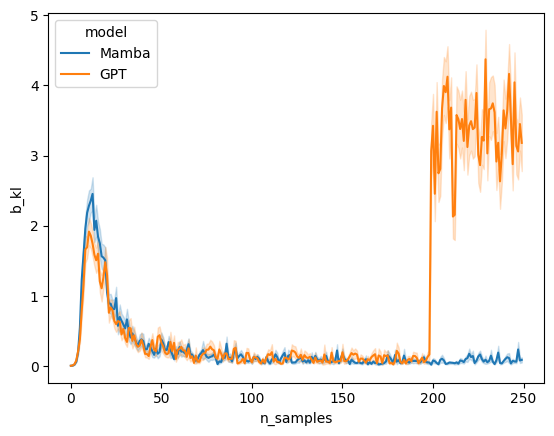

In [22]:
sns.lineplot(df, x='n_samples', y='b_kl', hue='model', errorbar=('se',1.0))